In [30]:
from helpers import *
import pandas as pd
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings 
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# ignore warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# auto reloading library (mainly for altering helpers.py)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
pd.set_option('display.max_columns', None)

In [32]:
training_filters = [
    {
        'feature': 'month',
        'operator': 'between',
        'value': [3, 9]
    }
]

validation_filters = [
    {
        'feature': 'date_forecast',
        'operator': 'between',
        'value': ['2020-05-01', '2020-07-01']
    }
]

test_filters = [
    {
        'feature': 'date_forecast',
        'operator': 'between',
        'value': ['2021-05-01', '2021-07-01']
    }
]

In [33]:
agg_strats = ['mean','00','15','30','45','min','max','std','median']
#agg_strats = ['mean']


m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = ['clip','sun_el_thr'],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
{'a': 5733.42, 'b': 1152.3, 'c': 999.6}


In [34]:
# get data
# X_train, y_train = m_wrap.get_train(aggregated=False,drop_val=True,drop_test=False)
# X_val, y_val = m_wrap.get_val(aggregated=False)
# X_test, y_test = m_wrap.get_test(aggregated=False)
# X_sub = m_wrap.get_sub(aggregated=False)
# X_test, y_test = m_wrap.get_test(aggregated=False)


X_train_agg, y_train_agg = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=True,y_scaled=True)
#X_val_agg, y_val_agg = m_wrap.get_val(aggregated=True)
X_test_agg, y_test_agg = m_wrap.get_test(aggregated=True,y_scaled=False)
X_sub_agg = m_wrap.get_sub(aggregated=True)

In [35]:
val_idx = X_train_agg['date_forecast'].between('2020-05-01', '2020-07-01')-1
ps = PredefinedSplit(test_fold=val_idx)

In [36]:
# imports
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# exclude datetime columns
X_train_agg = X_train_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])
#X_val_agg = X_val_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])

# automatically set types of columns for imputing and oneHotEncoding
categorical_features = X_train_agg.select_dtypes(include=['object']).columns.tolist()
impute_features = X_train_agg.loc[:, X_train_agg.isna().any()].columns.tolist()

print(f"categorical_features: {categorical_features}")
print(f"impute_features: {impute_features}")


columnTransformer = ColumnTransformer(
    transformers=[
        ('imputer', SimpleImputer(strategy='constant'),impute_features),
        ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ],
    remainder='passthrough',  # Dont drop remaining columns
    n_jobs=-1
)

mod = CatBoostRegressor(
)

open('status.csv', 'w').close()
# build the pipeline
mod_pipe = Pipeline(steps=[
    ('columnTransformer', columnTransformer),
    ('statusSaver', StatusSaver()),
    ('estimator', mod)
])

categorical_features: ['building_id']
impute_features: ['delta_forecast', 'mean_ceiling_height_agl:m', 'mean_cloud_base_agl:m', 'mean_snow_density:kgm3', 'mean_effective_cloud_cover_5h_mean', 'mean_GHI_lag_-1h', 'mean_GHI_lag_1h', 'mean_temp*GHI_lag_-1h', 'mean_temp*GHI_lag_1h', '00_ceiling_height_agl:m', '00_cloud_base_agl:m', '00_snow_density:kgm3', '00_effective_cloud_cover_5h_mean', '00_GHI_lag_-1h', '00_GHI_lag_1h', '00_temp*GHI_lag_-1h', '00_temp*GHI_lag_1h', '15_ceiling_height_agl:m', '15_cloud_base_agl:m', '15_snow_density:kgm3', '15_effective_cloud_cover_5h_mean', '15_GHI_lag_-1h', '15_GHI_lag_1h', '15_temp*GHI_lag_-1h', '15_temp*GHI_lag_1h', '30_ceiling_height_agl:m', '30_cloud_base_agl:m', '30_snow_density:kgm3', '30_effective_cloud_cover_5h_mean', '30_GHI_lag_-1h', '30_GHI_lag_1h', '30_temp*GHI_lag_-1h', '30_temp*GHI_lag_1h', '45_ceiling_height_agl:m', '45_cloud_base_agl:m', '45_snow_density:kgm3', '45_effective_cloud_cover_5h_mean', '45_GHI_lag_-1h', '45_GHI_lag_1h', '45_t

In [37]:
def std_per_sample(y, y_pred):
    return np.std((y - y_pred), axis=0)

std_scorer = make_scorer(std_per_sample, greater_is_better=False)

scoring = {
    'MAE': 'neg_mean_absolute_error',
    'STD': std_scorer
}

In [38]:
# run grid search
# gs = GridSearchCV(
#     mod_pipe,
#     param_grid={
#         # 'estimator__learning_rate': np.arange(0.3, 0.025, -0.025),
#         # 'estimator__max_depth': np.arange(13, 1, -1)
#         # 'estimator__n_estimators': np.arange(150,0,-10),
#         # 'estimator__colsample_bytree': np.arange(0.7,1.0001,0.025),
#         # 'estimator__reg_alpha': np.arange(0, 8, 0.5)
#         'estimator__reg_lambda': np.arange(0, 12, 0.5),
#         # 'estimator__min_child_weight': np.arange(0,10,0.5)
#     },
#     cv=ps,
#     n_jobs=-1,
#     scoring=scoring,
#     verbose=2,
#     refit='MAE'
# )

bs = BayesSearchCV(
    mod_pipe,
    search_spaces={
        'estimator__iterations': Integer(100, 2000),
        'estimator__depth': Integer(3, 14),
        # 'estimator__learning-rate': Real(30, 200),
        'estimator__l2_leaf_reg': Real(0, 30)
    },
    cv=ps,
    n_jobs=-1,
    scoring='neg_mean_absolute_error',
    verbose=2,
    n_iter=100,
    n_points=6,
    return_train_score=True
)

bs.fit(X_train_agg, y_train_agg)


Fitting 1 folds for each of 6 candidates, totalling 6 fits
0:	learn: 0.2109887	total: 154ms	remaining: 3m 48s
0:	learn: 0.2108897	total: 131ms	remaining: 1m 46s
1:	learn: 0.2059780	total: 260ms	remaining: 1m 45s
1:	learn: 0.2061515	total: 323ms	remaining: 4m
0:	learn: 0.2108967	total: 389ms	remaining: 8m 53s
2:	learn: 0.2015196	total: 410ms	remaining: 3m 22s
2:	learn: 0.2012435	total: 467ms	remaining: 2m 5s
3:	learn: 0.1969774	total: 503ms	remaining: 3m 6s
3:	learn: 0.1966653	total: 567ms	remaining: 1m 54s
4:	learn: 0.1926228	total: 672ms	remaining: 3m 19s
1:	learn: 0.2059919	total: 748ms	remaining: 8m 32s
4:	learn: 0.1922431	total: 734ms	remaining: 1m 58s
5:	learn: 0.1884224	total: 798ms	remaining: 3m 17s
6:	learn: 0.1843933	total: 927ms	remaining: 3m 16s
5:	learn: 0.1879642	total: 986ms	remaining: 2m 12s
7:	learn: 0.1804848	total: 1.09s	remaining: 3m 20s
2:	learn: 0.2012896	total: 1.15s	remaining: 8m 47s
6:	learn: 0.1839200	total: 1.19s	remaining: 2m 16s
8:	learn: 0.1767264	total: 1.

KeyboardInterrupt: 

In [ ]:
bs.best_params_

OrderedDict([('estimator__colsample_bytree', 0.5),
             ('estimator__learning_rate', 0.09003812294531022),
             ('estimator__max_depth', 10),
             ('estimator__min_child_weight', 10.0),
             ('estimator__n_estimators', 200),
             ('estimator__reg_alpha', 0.0),
             ('estimator__reg_lambda', 0.0)])

In [ ]:
model = bs.best_estimator_

<Axes: >

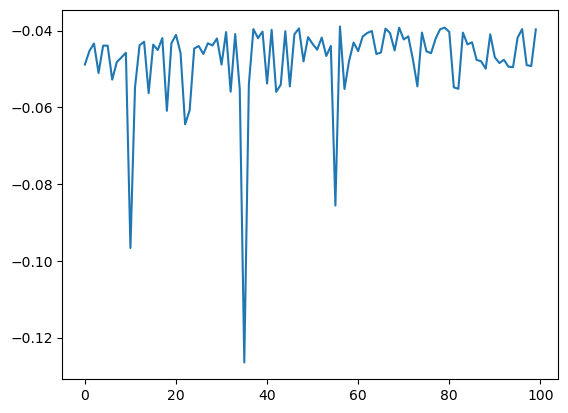

In [ ]:
# get val scores
sns.lineplot(bs.cv_results_['mean_test_score'])

In [ ]:
for key, values in gs.param_grid.items():
    pass

plt.figure(figsize=(20, 5))

sns.lineplot(y=gs.cv_results_['mean_test_MAE']*-1, x=list(map(str, values)))
plt.xticks(rotation=45);

plt.figure(figsize=(20, 5))
sns.lineplot(y=gs.cv_results_['mean_test_STD']*-1, x=list(map(str, values)))
plt.xticks(rotation=45);

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

<Figure size 2000x500 with 0 Axes>

In [ ]:
gs

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
             estimator=Pipeline(steps=[('columnTransformer',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          transformers=[('imputer',
                                                                         SimpleImputer(strategy='constant'),
                                                                         ['delta_forecast',
                                                                          'mean_ceiling_height_agl:m',
                                                                          'mean_cloud_base_agl:m',
                                                                          'mean_snow_density:kgm3',
                                                                          'mean_effective_cloud_cover_...
                                                     multi_strategy=None,
                                                     n_estimators=50,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'estimator__reg_lambda': array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
       11. , 11.5])},
             refit='MAE',
             scoring={'MAE': 'neg_mean_absolute_error',
                      'STD': make_scorer(std_per_sample, greater_is_better=False)},
             verbose=2)

In [ ]:
pred = pd.Series(model.predict(X_test_agg))

In [ ]:
mae = m_wrap.get_mae(pred,X_test_agg, y_test_agg, is_aggregated=True)
print(f'MAE: {mae}')

MAE: 147.26586644797936


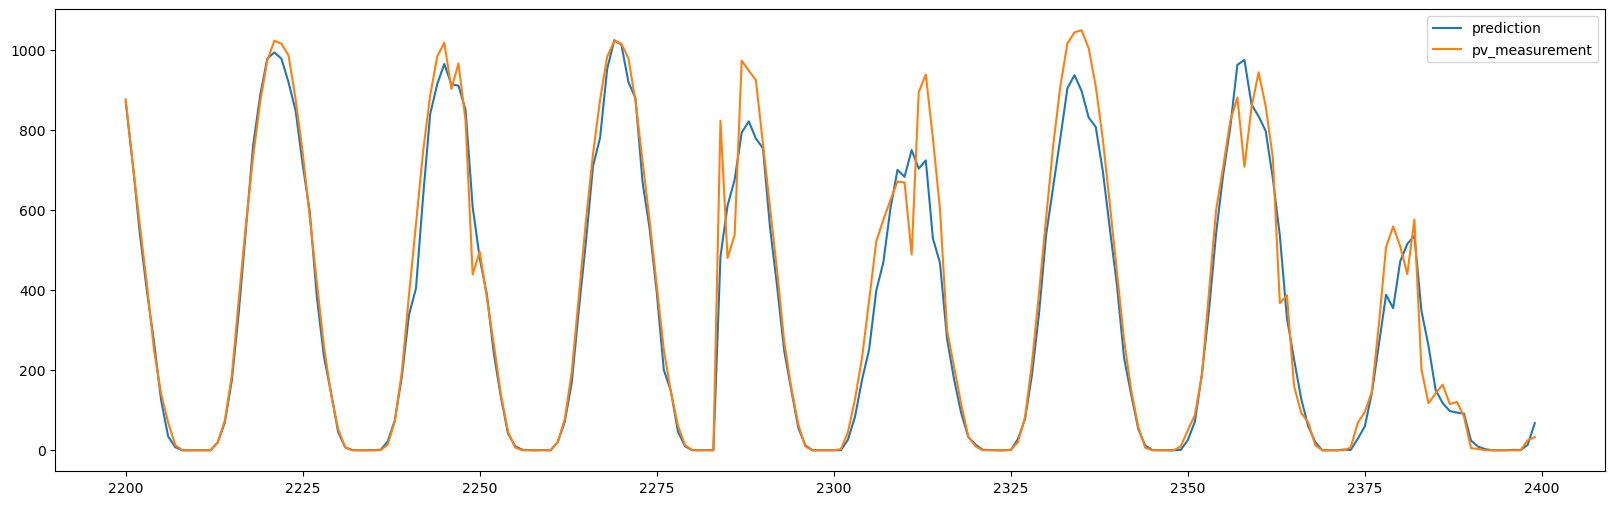

In [ ]:
m_wrap.plot_Pred_vs_PV(pred,y_test_agg,X_test_agg,start_idx=2200,end_idx=2400)

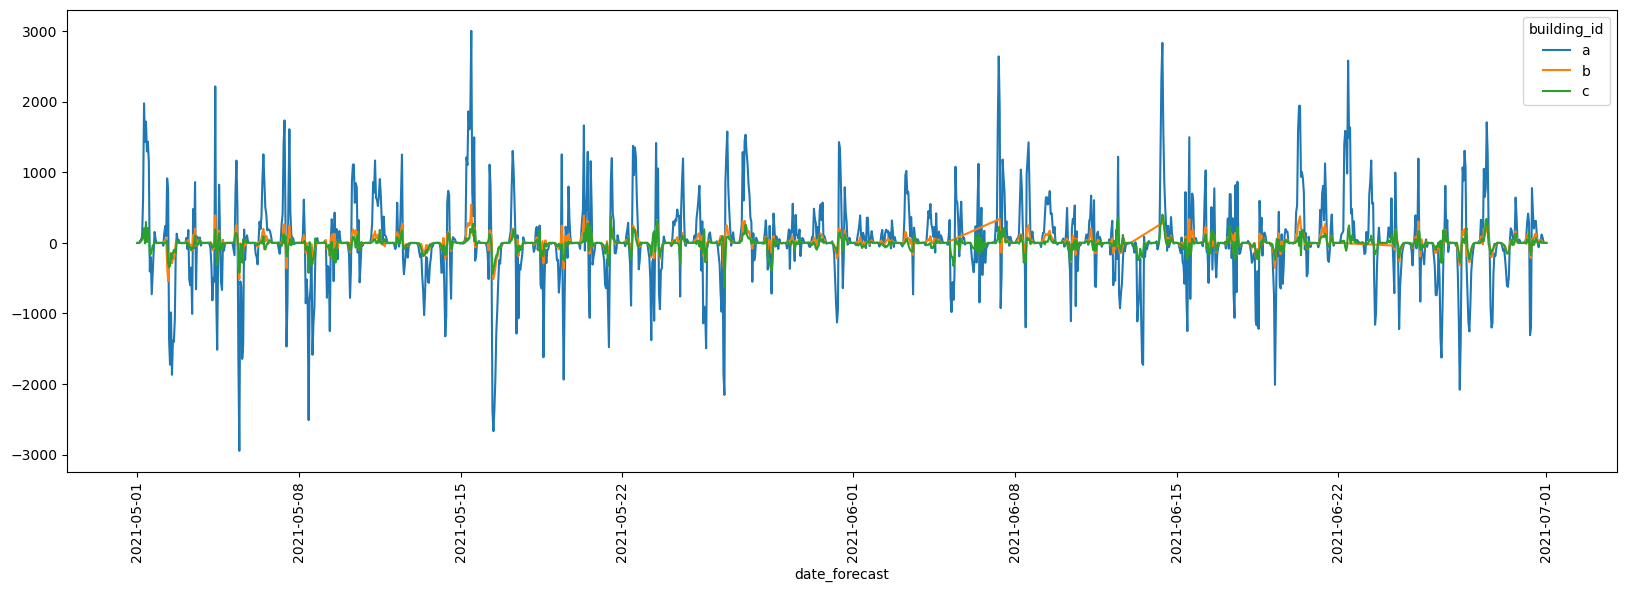

In [ ]:
m_wrap.plot_Residuals(pred,y_test_agg,X_test_agg)

In [ ]:
pred_sub = pd.Series(model.predict(X_sub_agg))
m_wrap.y_pred_to_csv(pred_sub, X_sub_agg, is_aggregated=True,name='new_aggregation.csv',sun_el_thr=-1)

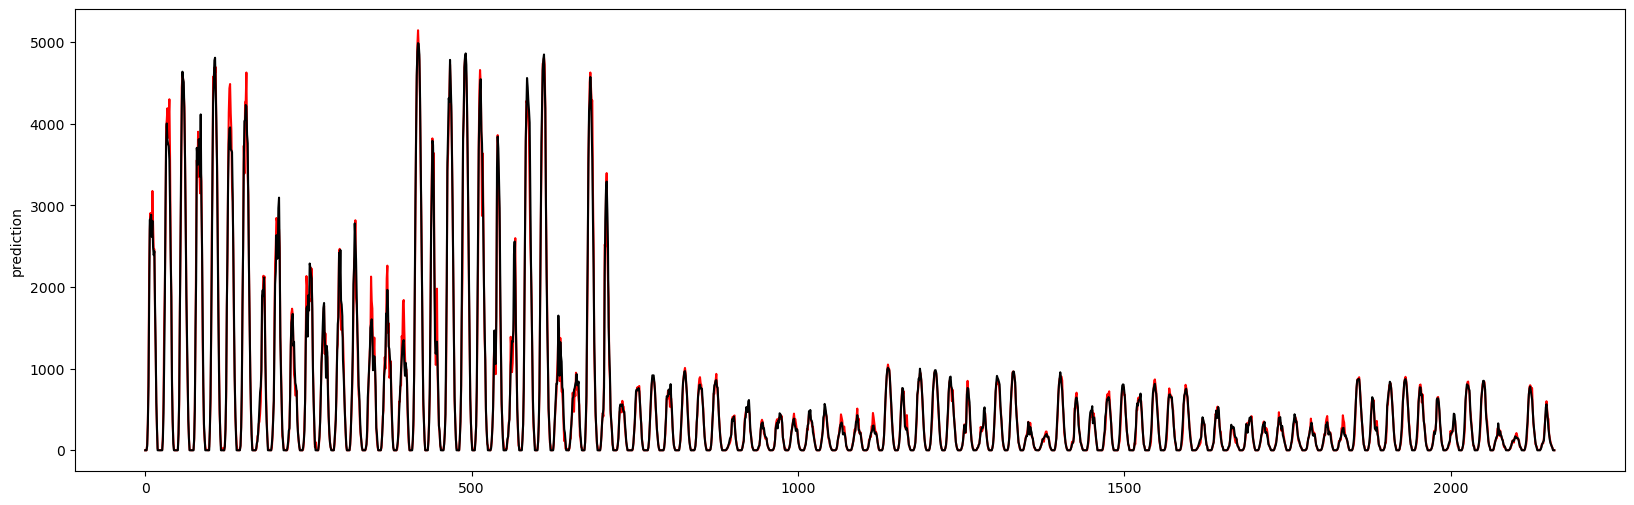

In [ ]:
m_wrap.plot_yPredSub_vs_submission(pred_sub,X_sub_agg,sub_file='./submission_files/152_029_xgboost.csv')